In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

## First, reading in PU.1 bQTL data
We store the peak names of significant PU.1 bQTL

In [3]:
# bqtl[0] is the list of significant bQTL
bqtl = pd.read_table('PU1.nominal.lead.centered.noSV.K10.txt', delimiter=' ', header=None)

In [9]:
bqtl_dict = {}
for i in range(bqtl.shape[0]):
    peakname = bqtl[0][i]
    varpos = bqtl[9][i]
    pval = bqtl[11][i]
    rsid = bqtl[7][i]
    bqtl_dict[peakname] = [varpos,pval,rsid]

## Reading motif score predictions

In [19]:
motifdisrupting = pd.read_table('PU1.pwm_gkmsvm.nominal.txt', delimiter='\t', header=None)

## Reading in LD data
This is to determine whether the PU.1 motif-altering variants are in LD ($r^2 > 0.8$) with PU.1 bQTL lead variants.

In [6]:
all_bqtl = pd.read_table('PU1.nominal.all.variants.txt', delimiter=' ', header=None)
ld = pd.read_table('PU1.leadsnps.r2_0.8.ld.txt', delimiter='\t', header=0)

In [7]:
ld_dict = {}
for i in range(ld.shape[0]):
    if ld['SNP_A'][i] in ld_dict:
        ld_dict[ld['SNP_A'][i]].append(ld['SNP_B'][i])
    else:            
        ld_dict[ld['SNP_A'][i]] = [ld['SNP_B'][i]]

## Determining the significant bQTLs that is closest to the center of the peak

In [10]:
closest_bqtl_dict = {}
#print(all_bqtl.head())
for i in range(all_bqtl.shape[0]):
    peakname = all_bqtl[0][i]
    varpos = all_bqtl[9][i]
    pval = all_bqtl[11][i]
    rsid = all_bqtl[7][i]
    dist = all_bqtl[6][i]
    if peakname in bqtl_dict:
        if rsid in ld_dict[bqtl_dict[peakname][2]]:
            if peakname not in closest_bqtl_dict:
                closest_bqtl_dict[peakname] = [varpos,pval,rsid,dist]
            else:
                if abs(dist) < abs(closest_bqtl_dict[peakname][3]):
                    closest_bqtl_dict[peakname] = [varpos,pval,rsid,dist]

In [17]:
mask = []
vals = []
count = 0
pu1motif_dict = {}
for i in range(motifdisrupting.shape[0]):
    peakname = motifdisrupting[3][i]
    pval = motifdisrupting[17][i]
    ref = motifdisrupting[12][i]
    alt = motifdisrupting[13][i]
    rsid = motifdisrupting[4][i]
    
    test = False
    if peakname in list(bqtl[0]):
        if pval < 5e-2 and min(ref, alt) > 0:
            if rsid in ld_dict[bqtl_dict[peakname][2]]:
                dist = motifdisrupting[5][i] - motifdisrupting[1][i] - 100 - 1
                test = True
                if peakname not in pu1motif_dict:
                    pu1motif_dict[peakname] = dist
                elif abs(dist) < abs(pu1motif_dict[peakname]):
                    pu1motif_dict[peakname] = dist
    mask.append(test)

mask = pd.Series(mask)

In [22]:
vals = []
for peak in pu1motif_dict:
    vals.append(pu1motif_dict[peak])

## Plotting the positions of PU.1 motif-altering variants
We visually see that PU.1 motif-altering variants are concentrated in the center of the peak.

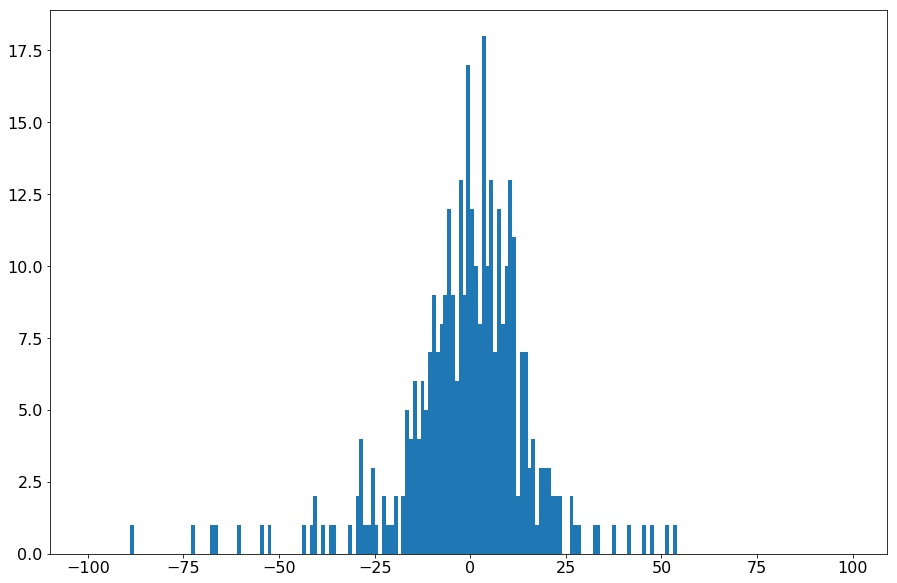

In [16]:
plt.figure(figsize = (15, 10)) 

# We can set the number of bins with the `bins` kwarg
counts = plt.hist(vals, bins=np.array(range(-100,100)))#, rwidth=0.55, color='black')
#axs[1].hist(blood_total, bins=100)

#plt.axvline(x = 94, color = 'r')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlabel('# of variants tagging (r2>0.8) blood cell trait associations', fontsize = 16)
plt.show()

## Counting how many PU.1 bQTLs have PU.1 motif-altering variants within the 50 bp center

In [26]:
counts = [0,0,0,0,0]
for peak in closest_bqtl_dict:
    if peak in pu1motif_dict:
        if abs(pu1motif_dict[peak]) <= 25:
            counts[0] += 1
        else:
            counts[1] += 1
    else:
        if abs(closest_bqtl_dict[peak][3]) <= 25:
            counts[2] += 1
        elif abs(closest_bqtl_dict[peak][3]) <= 100:
            counts[3] += 1
        else:
            counts[4] += 1

In [27]:
counts

[316, 38, 453, 241, 392]

In [34]:
df = pd.DataFrame({"location": ['Center 50 bp', 'Elsewhere', 'Center 50 bp', 'Elsewhere'],
                  "pu1motif": ['motif', 'motif', 'none', 'none'],
                  "number": counts[:4]})

In [35]:
df.to_csv("../motif_variant_location.txt", sep='\t', index=False)